# Création d'un modèle GAN qui respecte y2 = y1**2

In [1]:

%reset -f

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


In [2]:

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


## Création des briques du réseau GAN

In [3]:

latent_dim = 5

# coding discriminator
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # dim 2 en entrée
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Une sortie binaire
])

# coding generator
generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(latent_dim,)),  # dim 5 en entrée
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(2),
])


# optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# Compilation des modèles
# On n'a pas besoin de compiler le générateur
# Car on n'entraine que le discriminateur et le GAN (qui contient le generateur)
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False 

# coding & compilation GAN
gan = tf.keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="adam")


## Créations de fonctions suplémentaires

In [4]:

# Fonction pour générer des vrais échantillons
def generate_real_samples(n):
    # Génération de valeurs aléatoires entre -0.5 et 0.5
    x = np.random.rand(n) - 0.5
    y = x**2  # On les met au carré
    X_real = np.column_stack((x, y))  # Création des vrais échantillons X
    s_real = np.ones(n)  # Étiquettes des échantillons réels = 1 (ce sont de vraies données)
    return X_real, s_real

# Fonction pour générer des faux échantillons
def generate_fake_samples(generator, latent_dim, n):
    # Génération de bruit suivant une distribution gaussienne
    noise = np.random.randn(n, latent_dim)
    # Génération des faux échantillons à partir du générateur
    X_fake = generator.predict(noise)  # La sortie du générateur est de dimension 2
    s_fake = np.zeros(n)  # Étiquettes des faux échantillons = 0 (ce sont de fausses données)
    return X_fake, s_fake


2/2 [==============================] - 0s 1ms/step


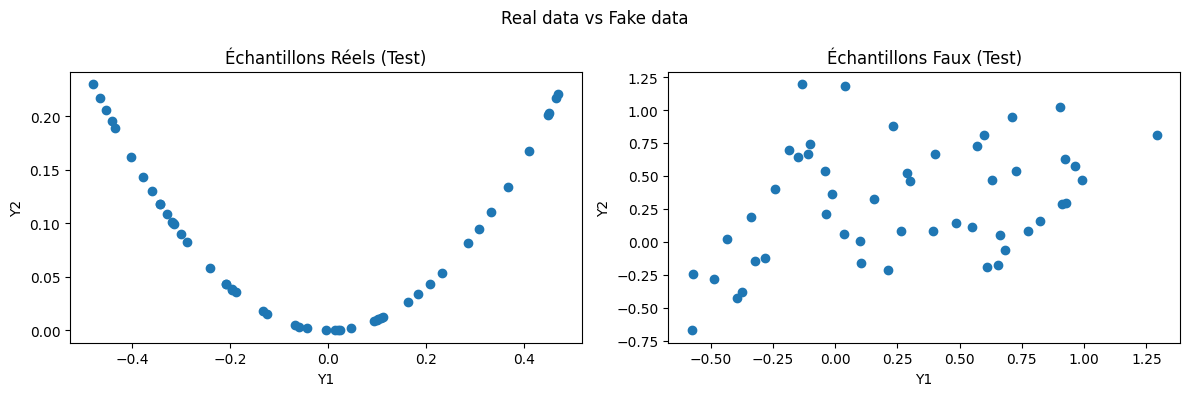

In [5]:

# Définition du nombre d'échantillons de test
n_test = 50

# Génération d'échantillons réels pour les tests
# Note : La fonction generate_real_samples() génère de vrais échantillons à partir de votre ensemble de données réelles.
real_batch_test, _ = generate_real_samples(n_test)

# Génération de faux échantillons pour les tests
fake_batch_test, _ = generate_fake_samples(generator, latent_dim, n_test)

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Premier sous-graphique pour les échantillons réels
axs[0].scatter(real_batch_test[:, 0], real_batch_test[:, 1])
axs[0].set_xlabel('Y1')  # Étiquette de l'axe des x
axs[0].set_ylabel('Y2')  # Étiquette de l'axe des y
axs[0].set_title('Échantillons Réels (Test)')  # Titre du graphique

# Deuxième sous-graphique pour les faux échantillons
axs[1].scatter(fake_batch_test[:, 0], fake_batch_test[:, 1])
axs[1].set_xlabel('Y1')  # Étiquette de l'axe des x
axs[1].set_ylabel('Y2')  # Étiquette de l'axe des y
axs[1].set_title('Échantillons Faux (Test)')  # Titre du graphique

# Titre global
plt.suptitle("Real data vs Fake data")

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
# Affichage des graphiques
plt.show()


## Entrainement du GAN

In [6]:

n_Iter = 10000
n_batch = 128 
latent_dim = 5

np.random.seed(seed)
tf.random.set_seed(seed)

# récupération du générateur et du discriminateur
generator, discriminator = gan.layers

# boucle principale d'entrainement
for i in range(n_Iter): 
    
    print(f'Iter : {i}')
    
    ################################################    
    # Phase 1 - Entrainement du discriminateur
    ################################################
    # Génération des batchs
    real_batch, real_batch_labels = generate_real_samples(n_batch)
    fake_batch, fake_batch_labels = generate_fake_samples(generator, latent_dim, n_batch)
    # On les concatène pour former un seul datasets (vrai + faux)
    X_fake_and_real = np.concatenate((fake_batch, real_batch), axis=0)
    s_fake_and_real_labels = np.concatenate((fake_batch_labels, real_batch_labels), axis=0)
    # On melange les data
    X_fake_and_real, s_fake_and_real_labels = shuffle(X_fake_and_real, s_fake_and_real_labels)
    
    # Entrainement effectif du discriminateur
    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_and_real, s_fake_and_real_labels)
    
    ################################################
    # Phase 2 - Entrainement du GAN (générateur)
    ################################################
    discriminator.trainable = False
    # Data pour entrainer le générateur 
    noise = np.random.randn(n_batch, latent_dim)
    
    # On veut que la sortie du GAN soit toujours égal ou proche à de 1.
    # On le force en gros (on veut forcer le gan : 'generateur' à produire des vraies data)
    y = np.ones(n_batch) 
    
    # Entrainement effectif du GAN
    gan.train_on_batch(noise, y)
    
    
    # Sauvegarde des graphiques toutes les 200 itérations
    if i % 200 == 0:
        noise = np.random.randn(n_batch, latent_dim)
        y_generator = generator.predict(noise)
        plt.scatter(y_generator[:, 0], y_generator[:, 1])
        plt.title(f'Échantillons Générés (Itération {i})')
        plt.xlabel('Y1')
        plt.ylabel('Y2')
        plt.savefig(f'imgs_gen_samples/{i}.png')
        plt.close()  # Fermer le graphique après la sauvegarde

# Affichage des graphiques générés (facultatif)
#plt.show()



Iter : 0
4/4 [==============================] - 0s 802us/step
Iter : 1
4/4 [==============================] - 0s 696us/step
Iter : 2
4/4 [==============================] - 0s 749us/step
Iter : 3
4/4 [==============================] - 0s 766us/step
Iter : 4
4/4 [==============================] - 0s 653us/step
Iter : 5
4/4 [==============================] - 0s 782us/step
Iter : 6
4/4 [==============================] - 0s 979us/step
Iter : 7
4/4 [==============================] - 0s 828us/step
Iter : 8
4/4 [==============================] - 0s 758us/step
Iter : 9
4/4 [==============================] - 0s 734us/step
Iter : 10
4/4 [==============================] - 0s 689us/step
Iter : 11
4/4 [==============================] - 0s 648us/step
Iter : 12
4/4 [==============================] - 0s 703us/step
Iter : 13
4/4 [==============================] - 0s 685us/step
Iter : 14
4/4 [==============================] - 0s 656us/step
Iter : 15
4/4 [==============================] - 0s 772us/step
It

4/4 [==============================] - 0s 714us/step


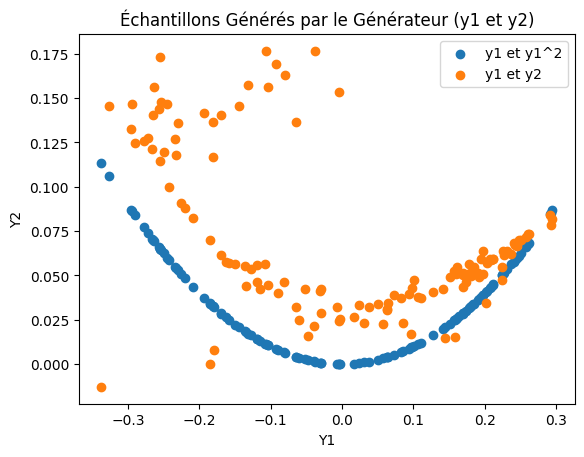

In [7]:

np.random.seed(42)
tf.random.set_seed(42)

# Test du générateur
# récupération du générateur et du discriminateur
# generator, discriminator = gan.layers

# Génération de bruit
noise = np.random.randn(n_batch, latent_dim)  # Génération de bruit suivant une loi gaussienne
y_generator = generator.predict(noise)

# Scatter plot pour y1 et y1^2
plt.scatter(y_generator[:, 0], y_generator[:, 0]**2, label='y1 et y1^2')
plt.xlabel('Y1')  # Étiquette de l'axe des x
plt.ylabel('Y1^2')  # Étiquette de l'axe des y
plt.title('Échantillons Générés par le Générateur (y1 et y1^2)')  # Titre du graphique

# Scatter plot pour y1 et y2
plt.scatter(y_generator[:, 0], y_generator[:, 1], label='y1 et y2')
plt.xlabel('Y1')  # Étiquette de l'axe des x
plt.ylabel('Y2')  # Étiquette de l'axe des y
plt.title('Échantillons Générés par le Générateur (y1 et y2)')  # Titre du graphique

plt.legend()  # Ajoute une légende pour distinguer les deux scatter plots
plt.show()
